---
# NN-Based Optimal Control
---

In [1]:
# SciML Tools
using DifferentialEquations, DataDrivenDiffEq, SciMLSensitivity, DataDrivenSparse
using Optimization, OptimizationOptimisers, OptimizationOptimJL 

# Standard Libraries
using LinearAlgebra, Statistics

# External Libraries
using ComponentArrays, Lux, Zygote, FiniteDiff, ForwardDiff, Plots, LaTeXStrings, StableRNGs, QuadGK, StochasticAD, Distributions

# Set a random seed for reproducible behaviour
rng = StableRNG(4578478478) 

StableRNGs.LehmerRNG(state=0x00000000000000000000000221cc131d)

---
## Define NN Controller

In [2]:
# Define controller
const ctr = Lux.Chain(Lux.Dense(4, 64, relu), Lux.Dense(64, 1, sigmoid))
# Get the initial parameters and state variables of the model
p, st = Lux.setup(rng, ctr)
const st_ctr = st

(layer_1 = NamedTuple(), layer_2 = NamedTuple())

In [33]:
mumax(T) = -0.00266071 .* T .^ 2 .+ 0.18037857 .* T .- 2.86700000
xmax(T) = 0.76071429 .* T .^ 2 .- 55.69857143 .* T .+ 1058.18000000
pmax(T) = 0.57678571 .* T .^ 2 .- 42.06642857 .* T .+ 838.23200000
ypx(T) = -0.02071429 .* T .^ 2 .+ 1.90357143 .* T .- 26.44400000
yx(T) = -0.00016071 .* T .^ 2 .+ 0.00917857 .* T .- 0.09160000

function ethanoll!(du, u, p, t)
    ctr_hat = ctr(u, p, st_ctr)[1]
    h, cp, d, frec, v, ks, ki, m, n, mx, mp, Tsp = [-511 3.82 1060 31 59.66 4.1 4e-3 1.0 1.5 0.2 0.1 30.0]
    X = u[1]
    S = u[2]
    P = u[3]
    T = u[4]
    #* real(((1 - (P / pmax(T))) + 0im)^(n) * X) * ℯ^((-1) * ki * S)# *(ℯ)^(-ki*S) * ((1-(X/xmax(T)))^m) * (((1-(P/pmax(T)))^n)*X)
    du[1] = mumax(T) * (S / (S + ks)) * real((1 - (X / xmax(T)) + 0im)^m) 
    du[2] = -((du[1] / yx(T)) + (mx * X))
    du[3] = (ypx(T) * du[1]) + (mp * X)
    du[4] = (h / (d * cp)) * du[2] - (frec / v) * ctr_hat[1]
end


ethanoll! (generic function with 1 method)

---
## Randomly Initialized Controller

In [34]:
# Define the problem
u0 = [2.75f0, 150.0f0, 0.0f0, 30.0f0]
tspan = (0.0f0, 33.0f0)
prob_nn = ODEProblem(ethanoll!, u0, tspan, p)
# prob = EnsembleProblem(prob_nn)

ODEProblem with uType Vector{Float32} and tType Float32. In-place: true
timespan: (0.0f0, 33.0f0)
u0: 4-element Vector{Float32}:
   2.75
 150.0
   0.0
  30.0

In [57]:
# simulation time (0,30)
sol = solve(prob_nn, Vern7(), abstol = 1e-5, reltol = 1e-5)

retcode: Success
Interpolation: specialized 7th order lazy interpolation
t: 30-element Vector{Float32}:
  0.0
  0.10028694
  0.2118547
  0.3365664
  0.4797747
  0.64840955
  0.87031597
  1.1467403
  1.4760885
  1.9142445
  2.4399219
  3.0520163
  3.8300414
  ⋮
 13.945141
 17.290653
 20.165686
 22.217115
 23.797659
 25.276672
 26.694275
 28.063759
 29.414927
 30.749931
 32.22248
 33.0
u: 30-element Vector{Vector{Float32}}:
 [2.75, 150.0, 0.0, 30.0]
 [2.7640543, 149.58542, 0.1965865, 30.000208]
 [2.7796853, 149.12398, 0.415405, 30.00047]
 [2.7971528, 148.6079, 0.6601521, 30.000797]
 [2.8172045, 148.0149, 0.9413945, 30.00122]
 [2.8408077, 147.31609, 1.2728426, 30.001785]
 [2.871853, 146.39566, 1.7094471, 30.002636]
 [2.910504, 145.24773, 2.2540457, 30.00387]
 [2.956525, 143.87798, 2.903988, 30.005598]
 [3.0177014, 142.0522, 3.7705073, 30.008337]
 [3.091029, 139.85632, 4.8129835, 30.012302]
 [3.1763241, 137.29185, 6.030913, 30.017881]
 [3.2846217, 134.01997, 7.5855966, 30.026516]
 ⋮
 [4.68

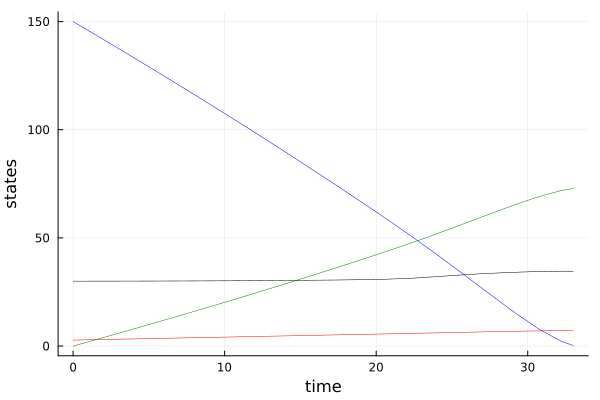

In [61]:
function plot_ensemble(sol)
    pl = plot(legend=false, xlabel="time", ylabel="states")
    plot!(pl, sol.t, [u[1] for u in sol.u], color=:red, linewidth=0.5)
    plot!(pl, sol.t, [u[2] for u in sol.u], color=:blue, linewidth=0.5)
    plot!(pl, sol.t, [u[3] for u in sol.u], color=:green, linewidth=0.5)
    plot!(pl, sol.t, [u[4] for u in sol.u], color=:black, linewidth=0.5)
    # plot!(pl, [tspan[1], tspan[2]], [30], style=:dash, color=:black, linewidth=2.5)
    pl
end

plot_ensemble(sol)

---
## Define Cost Function

In [64]:
# Setting up the training loop
function predict(θ)
    _prob = remake(prob_nn, p=θ)
    sol = solve(ODEProblem(_prob), Vern7(), abstol = 1e-5, reltol = 1e-5, sensealg=BacksolveAdjoint(autojacvec=ReverseDiffVJP()))
    A = convert(Array, sol)
end

function loss(θ)
    State_hat = predict(θ)

    # dim = (#time steps, #trajectories)
    cs = @view (ctr(State_hat, θ, st_ctr)[1])[1, :, :]
    X = @view State_hat[1, :, :]
    S = @view State_hat[2, :, :]
    P = @view State_hat[3, :, :]
    T = @view State_hat[4, :, :]


    # stagecost
    sum((X .- 30.0) .^ 2 + (cs) .^ 2 / 5)/10
end

loss (generic function with 1 method)

---
## Optimal Control


In [69]:
# Run the training process!
losses = Float64[]

callback = function (p, l)
    push!(losses, l)
    if length(losses) % 50 == 0
        sol = solve(prob_nn, Vern7(), abstol = 1e-5, reltol = 1e-5)
        display(plot_ensemble(sol))
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    return false
end

adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float64}(p))

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [-0.21750110387802124 0.2766962945461273 -0.08624516427516937 -0.20353147387504578; 0.08161100000143051 0.28101828694343567 0.2001902163028717 -0.05288867652416229; … ; 0.2756337821483612 0.12145284563302994 -0.16369090974330902 -0.11734049022197723; 0.08039423078298569 0.2347666621208191 -0.29369989037513733 -0.026415478438138962], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.2856011986732483 0.1639893651008606 … -0.17443184554576874 0.23140017688274384], bias = [0.0;;]))

In [70]:
res = Optimization.solve(optprob, ADAM(), callback=callback, maxiters=500)
println("Training loss after $(length(losses)) iterations: $(losses[end])")


LoadError: MethodError: no method matching ODEProblem(::ODEProblem{Vector{Float32}, Tuple{Float32, Float32}, true, ComponentVector{Float64, Vector{Float64}, Tuple{Axis{(layer_1 = ViewAxis(1:320, Axis(weight = ViewAxis(1:256, ShapedAxis((64, 4), NamedTuple())), bias = ViewAxis(257:320, ShapedAxis((64, 1), NamedTuple())))), layer_2 = ViewAxis(321:385, Axis(weight = ViewAxis(1:64, ShapedAxis((1, 64), NamedTuple())), bias = ViewAxis(65:65, ShapedAxis((1, 1), NamedTuple())))))}}}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(ethanoll!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem})

[0mClosest candidates are:
[0m  ODEProblem(::Any, [91m::Any[39m, [91m::Any[39m)
[0m[90m   @[39m [35mSciMLBase[39m [90m~/.julia/packages/SciMLBase/ynHlA/src/problems/[39m[90m[4mode_problems.jl:187[24m[39m
[0m  ODEProblem(::Any, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mSciMLBase[39m [90m~/.julia/packages/SciMLBase/ynHlA/src/problems/[39m[90m[4mode_problems.jl:187[24m[39m
[0m  ODEProblem([91m::SciMLBase.AbstractODEFunction[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any...[39m; kwargs...)
[0m[90m   @[39m [35mSciMLBase[39m [90m~/.julia/packages/SciMLBase/ynHlA/src/problems/[39m[90m[4mode_problems.jl:183[24m[39m
[0m  ...


In [ ]:
sol = solve(ODEProblem(ethanoll!, u0, tspan, res.u), Vern7(), abstol = 1e-5, reltol = 1e-5)

plot_ensemble(sol)